In [1]:
!pip install pystan==2.19.1.1
!pip install prophet

     |████████████████████████████████| 65 kB 4.8 MB/s 
     |████████████████████████████████| 49 kB 7.6 MB/s 
     |████████████████████████████████| 43 kB 2.8 MB/s 
  Created wheel for prophet: filename=prophet-1.0.1-py3-none-any.whl size=6638269 sha256=97405c5b3b5840b947c244efa73a0d3cd4ab3b8e9133ffb32a204ae96a9a733e
  Stored in directory: /root/.cache/pip/wheels/4e/a0/1a/02c9ec9e3e9de6bdbb3d769d11992a6926889d71567d6b9b67
Successfully built prophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.


In [2]:
import pandas as pd
from prophet import Prophet
import plotly.express as px
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
import numpy as np
import itertools

In [3]:
data =pd.read_csv("/content/drive/MyDrive/Colab Notebooks/bitstampUSD_1-min_data_2012-01-01_to_2020-12-31.csv")

In [4]:
data

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
4727772,1609372560,28801.47,28829.42,28785.64,28829.42,0.965221,27804.572129,28806.429798
4727773,1609372620,28829.42,28863.90,28829.42,28857.06,2.368831,68332.350629,28846.441863
4727774,1609372680,28850.49,28900.52,28850.49,28882.82,2.466590,71232.784464,28879.056266
4727775,1609372740,28910.54,28911.52,28867.60,28881.30,7.332773,211870.912660,28893.695831


In [5]:
data['price'] = (data['High']+ data['Low'])/2
data.drop(['Open','Close','Volume_(BTC)','Volume_(Currency)', 'Weighted_Price','High','Low'],axis=1, inplace=True)#
data['Timestamp'] = pd.to_datetime(data['Timestamp'],unit='s')
data = data.set_index('Timestamp')
data = data.resample('1D').mean()
data = data.dropna()
data

,price
Timestamp,
2011-12-31,4.473750
2012-01-01,4.806667
2012-01-02,5.000000
2012-01-03,5.252500
2012-01-04,5.211667
...,...
2020-12-27,27044.036733
2020-12-28,26963.621417
2020-12-29,26670.453208


In [6]:
data['ds'] = data.index
data=data.rename(columns={"price":"y"})

In [8]:
px.area(data, x='ds', y='y')

In [9]:
m = Prophet(daily_seasonality=True)
m.fit(data)

In [10]:
df_cv = cross_validation(m, initial='730 days', period='60 days', horizon = '180 days')

INFO:prophet:Making 40 forecasts with cutoffs between 2014-02-06 00:00:00 and 2020-07-04 00:00:00


  0%|          | 0/40 [00:00<?, ?it/s]

In [11]:
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,18 days,5.364440e+06,2316.126103,1378.336644,0.296945,0.210397,0.285306,0.447184
1,19 days,5.507647e+06,2346.837631,1395.968043,0.302425,0.214281,0.290217,0.443011
2,20 days,5.706957e+06,2388.923784,1417.899046,0.308014,0.217256,0.295363,0.438873
3,21 days,5.933604e+06,2435.899072,1440.354535,0.313478,0.220631,0.300372,0.436092
4,22 days,6.149567e+06,2479.831999,1462.527362,0.318997,0.224337,0.305380,0.433275


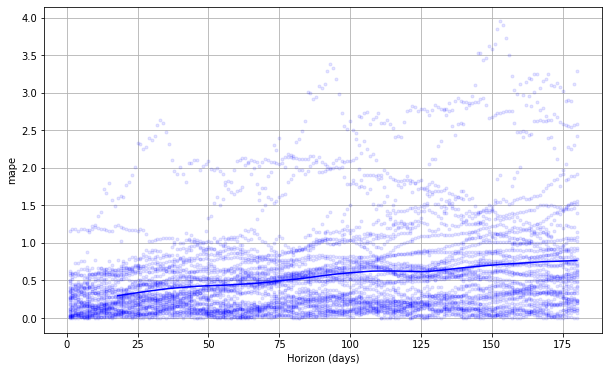

In [12]:
fig = plot_cross_validation_metric(df_cv, metric='mape')

In [13]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'seasonality_mode':['additive', 'multiplicative'],
    'holidays_prior_scale':[0.01, 0.1, 1.0, 10.0]
}

In [14]:
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here


In [16]:
cutoffs = pd.to_datetime(['2016-02-15', '2017-08-15', '2019-02-15'])
for params in all_params:
    print(params)
    m = Prophet(**params).fit(data)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])
    print("++++++++++++++++++++++++")

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'holidays_prior_scale': 0.01}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bcfd2210>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'holidays_prior_scale': 0.1}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77d0cad450>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1.0}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bd04a050>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bcf0d850>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 0.01}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bcf0d410>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 0.1}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bceea610>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bceebe90>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10.0}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bd0411d0>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'holidays_prior_scale': 0.01}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bd065f50>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'holidays_prior_scale': 0.1}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bcf53b50>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1.0}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bd106610>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bd1d29d0>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 0.01}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bceb8190>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 0.1}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bd041250>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77cf84ea50>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10.0}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bd106750>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 0.01}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bd0a6850>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 0.1}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bd062b50>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1.0}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bd0a6910>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bd007fd0>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 0.01}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bd007850>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 0.1}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bd0dee90>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bd062650>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10.0}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bd003d50>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 0.01}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bd017310>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 0.1}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bd0173d0>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1.0}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bd150110>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bd19a150>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 0.01}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bd088090>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 0.1}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bd150710>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bceeac90>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10.0}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bcf1a9d0>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'holidays_prior_scale': 0.01}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bd1d9790>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'holidays_prior_scale': 0.1}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bceeb150>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1.0}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bd065790>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bcf582d0>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 0.01}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bd150950>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 0.1}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bd106610>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bd042410>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10.0}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bd11fa10>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'holidays_prior_scale': 0.01}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bd19a410>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'holidays_prior_scale': 0.1}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77cf84ea50>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1.0}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bd150e50>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bce85690>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 0.01}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bd1e6bd0>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 0.1}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bd1d2510>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bd0ed350>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10.0}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bcf46890>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 0.01}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bcf59510>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 0.1}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bcf49b90>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1.0}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bcf1a710>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bcf46b50>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 0.01}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bcf46990>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 0.1}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bd0886d0>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bd11f610>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10.0}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bcf1a990>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 0.01}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bcfbf690>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 0.1}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bcfb6bd0>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1.0}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bd0ce0d0>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bd0de9d0>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 0.01}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bceeb750>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 0.1}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bcfbdd50>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bce808d0>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10.0}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bcf58910>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'holidays_prior_scale': 0.01}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bcfbd750>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'holidays_prior_scale': 0.1}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bce80250>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1.0}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bcf89350>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bd1cfb90>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 0.01}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bcf72e50>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 0.1}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bce80350>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bd1cf310>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10.0}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bd088410>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'holidays_prior_scale': 0.01}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bd1f1e90>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'holidays_prior_scale': 0.1}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77d0e34950>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1.0}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bd0dbe50>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bcfbfa90>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 0.01}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bcf0d590>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 0.1}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bd132050>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bcf46a10>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10.0}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bd062410>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 0.01}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bcf9ef50>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 0.1}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bd065e50>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1.0}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bcf62f90>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bd041450>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 0.01}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bd1e6d90>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 0.1}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bd1f1310>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bcf62dd0>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10.0}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bd11f1d0>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 0.01}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77d0df3290>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 0.1}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bd1f10d0>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1.0}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bd007ed0>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bd0dbe50>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 0.01}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bd1a2690>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 0.1}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bd132550>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bcfbfa90>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10.0}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bceb8fd0>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'holidays_prior_scale': 0.01}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bcfd2890>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'holidays_prior_scale': 0.1}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bcdfdd90>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1.0}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bd041250>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bd1d9410>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 0.01}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bd017c50>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 0.1}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bd007ad0>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bceb8950>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10.0}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bcdfd090>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'holidays_prior_scale': 0.01}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bcf72b50>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'holidays_prior_scale': 0.1}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bcfb2810>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1.0}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bcfd2a10>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bcf445d0>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 0.01}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bd1d9650>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 0.1}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bd153f90>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bdc1fc90>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10.0}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bd19a8d0>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 0.01}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bd19ab90>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 0.1}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bd19a810>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1.0}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bcf947d0>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bd18c790>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 0.01}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bcdfd3d0>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 0.1}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bdc1f1d0>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bd085b90>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10.0}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bd0de750>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 0.01}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bcf7f110>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 0.1}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bcfbed10>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 1.0}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bcf5a250>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'holidays_prior_scale': 10.0}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bcf9e710>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 0.01}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bd017f50>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 0.1}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bd1d2790>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 1.0}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77d1371190>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


++++++++++++++++++++++++
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 10.0}


INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bcfbeed0>


++++++++++++++++++++++++


In [17]:
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
tuning_results

,changepoint_prior_scale,seasonality_prior_scale,seasonality_mode,holidays_prior_scale,rmse
0,0.001,0.01,additive,0.01,2283.162017
1,0.001,0.01,additive,0.10,2283.162017
2,0.001,0.01,additive,1.00,2283.162017
3,0.001,0.01,additive,10.00,2283.162017
4,0.001,0.01,multiplicative,0.01,2163.432159
...,...,...,...,...,...
123,0.500,10.00,additive,10.00,1449.679349
124,0.500,10.00,multiplicative,0.01,1062.498140
125,0.500,10.00,multiplicative,0.10,1062.498140
126,0.500,10.00,multiplicative,1.00,1062.498140


In [18]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 0.01}


In [20]:
m = Prophet(**best_params).fit(data)  # Fit model with given params
df_cv = cross_validation(m, cutoffs=cutoffs, horizon='60 days', parallel="processes")

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f77bd0de210>


In [21]:
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,6 days,259073.953594,508.993078,378.289493,0.147078,0.178856,0.160495,0.333333
1,7 days,258875.706201,508.798296,379.181117,0.152683,0.186374,0.167505,0.333333
2,8 days,271731.306362,521.278531,384.383205,0.156618,0.194827,0.172826,0.333333
3,9 days,309955.772375,556.736717,405.746671,0.163060,0.200723,0.180873,0.333333
4,10 days,407159.184130,638.090263,465.512625,0.178020,0.205369,0.198287,0.333333


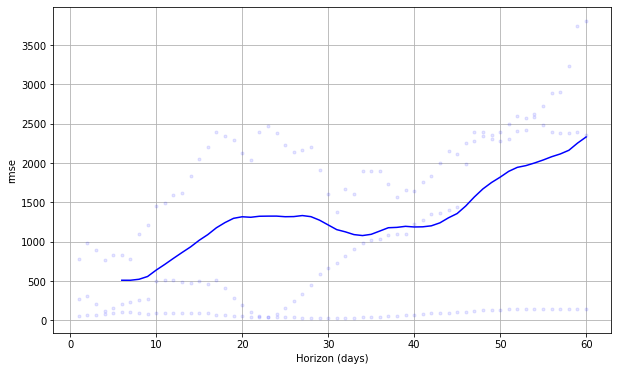

In [22]:
fig = plot_cross_validation_metric(df_cv, metric='rmse')

In [23]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
3646,2021-12-27
3647,2021-12-28
3648,2021-12-29
3649,2021-12-30
3650,2021-12-31


In [24]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3646,2021-12-27,24148.533636,15019.818891,32232.864833
3647,2021-12-28,23917.793545,15098.623238,31689.291988
3648,2021-12-29,23636.686084,15058.368743,31463.936509
3649,2021-12-30,23310.568471,14433.311065,30918.994398
3650,2021-12-31,22754.649938,14045.506131,30503.459617


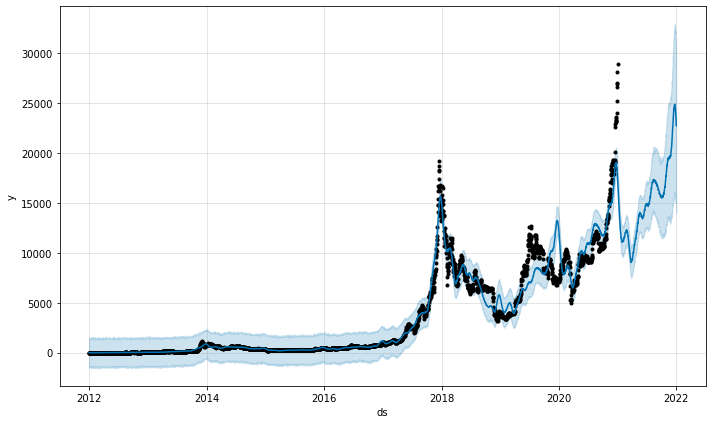

In [26]:
fig1 = m.plot(forecast)

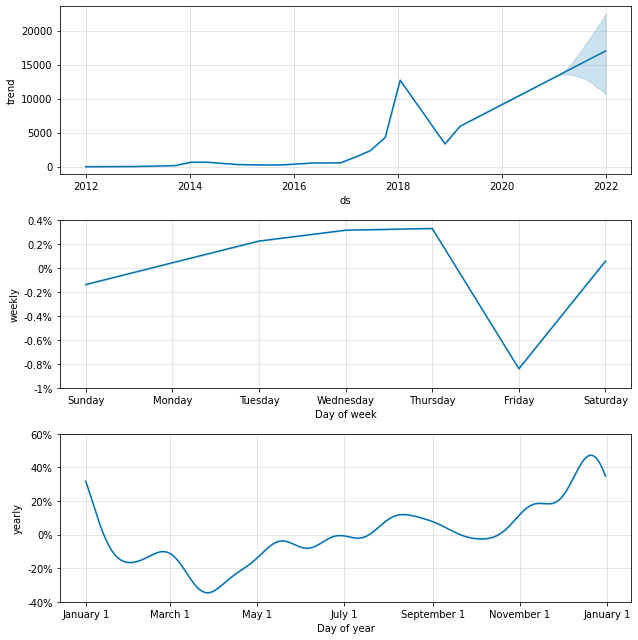

In [27]:
fig2 = m.plot_components(forecast)

In [28]:
plot_plotly(m, forecast)